### This notebook will provide the minimal code needed to generate your own QUBO allocations and save them to a numpy record array
#### (Note that there are many other functions available in the source-code that provide other tools for working with the data, so give them a look if you're interested.)

In [1]:
# Import the main scripts (Benchmark internally imports the other scripts so you can just call this)
import sys
from pathlib import Path
sys.path.insert(1,  str(Path().resolve().parent / 'src')  ) # Do this to access the python scripts in 

from benchmark import *
import numpy as np

In [2]:
# We need to define where the circuits we would like to find allocations for are located
# It is assumed that they are formatted like 'qasm' files (easily generated using Qiskit's QuantumCircuit object .qasm() method)
# where the first 3 lines don't contain any gate operations (look at one of the circuits we reference here for an example)

# For ease of example we just point to the benchmarks sets we used in the paper
# We use pathlib just for an OS agnostic call (you could insert your own absolute path)
from pathlib import Path

loc = str(Path().resolve().parent / 'benchmarks' / 'circuits')
print(loc)

C:\work\QUBO-for-Qubit-Allocation\benchmarks\circuits


In [4]:
# To get a list of the circuits in the location of loc, we generate a 'property array' for the circuits
# if you don't already have one use 'calc_properties' function, we just load an old one
prop_loc = str(Path().resolve().parent / 'benchmarks' / 'data' / 'property array' / 'circ_prop_with_depth_2020-08-20-15.28.53.npy')
prop_arr = np.load(prop_loc, allow_pickle=True)

# There are some 16 qubit circuits in the prop_arr as is, so we remove them here
prop_arr = np.delete(prop_arr, np.where( prop_arr['logical_qubit']==16)[0] )

# Now we can just grab the list of circuit names using the 'circuit' record in the array
circ_list = prop_arr['circuit']
print('Here are the first 5 circuits in circ_list: ', '\n', circ_list[:5])

Here are the first 5 circuits in circ_list:  
 ['0410184_169.qasm' '3_17_13.qasm' '4gt10-v1_81.qasm' '4gt11_82.qasm'
 '4gt11_83.qasm']


These are the connected edges for melbourne:  
 [[1, 0], [1, 2], [2, 3], [4, 3], [4, 10], [5, 4], [5, 6], [5, 9], [6, 8], [7, 8], [9, 8], [9, 10], [11, 10], [11, 3], [11, 12], [12, 2], [13, 1], [13, 12], [14, 0], [14, 13]]
This hardware graph has:  15 qubits.


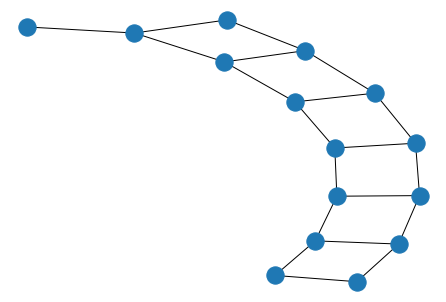

In [5]:
# We also have to generate a hardware graph to feed into the benchmark function
# It expects this to be a networkx graph object
import networkx as nx

graph = nx.Graph()

# At this point, whatever you define this graph to look like will decide what the hardware graph is for the allocations
# We use melbourne for simplicity (and because have error-rate data for it)

# To get the hardware edges for melbourne, we use our 'hardware_graph' function
mel_edges = hardware_edges('melbourne')
print('These are the connected edges for melbourne: ', '\n', mel_edges)

graph.add_edges_from(mel_edges)

# You can also draw the graph if you want to see what it looks like
nx.draw(graph)

# We need the number of physical qubits in the hardware graph - we grab this from the graph itself
n_p = len(graph)
print('This hardware graph has: ', n_p, 'qubits.')

In [8]:
# The only thing left to do is specify the one and two qubit error rates
# In this case, we use the calibration CSV for melbourne that IBM QX provides
# And just have to specify that csv's location - the benchmark function handles the rest

err_loc = str(Path().resolve().parent / 'examples' / 'IBM_qc_csv' / 'ibmq_16_melbourne(july-12).csv')

In [11]:
# Now we just have to run the benchmark function with the fields we just defined

benchmark(circuit_list = circ_list,
          loc = loc,
          n_p = n_p,
          graph = graph,
          err_graph = err_loc,
          num_samples = 1000)

### If you want to change the coefficient form used, go into the 'benchmark.py' file and edit the coefficient forms defined as 'heur1', 'heur2' and 'heur3'
### Notice how each of them is a matrix where the positions in the matrix mirror the coefficients as defined in the paper and try to follow the same form
### When encoding your metric as a matrixy

151it [22:47,  9.06s/it]


In [13]:
# The previous function will save a numpy record array of the data from the run to 'QUBO-for-Qubit-Allocation/benchmarks/data/benchmark array'
# that can be loaded using numpy.load(filename, allow_pickle=True). Below we load a run of a benchmark array I made using the set of benchmark circuits

bm_arr = np.load( str(Path().resolve().parent / 'benchmarks' / 'data' / 'benchmark array' / 'benchmark-results_2020-08-31-19.25.15.npy'), allow_pickle=True)

In [20]:
# If we query the dtype of the array we can see what all the records are
print('This is the base benchmark array dtypes: ', bm_arr.dtype, '\n')

# The record 'data_array' contains a record array of all of the allocations from the simulated annealing run. Lets access a specific one:
data =  bm_arr['data_array'][6]
print('This is the data array dtypes: ', data.dtype, '\n')

# Here are the first 3 allocations:
print(data[:3])

# By default the data arrays should be sorted by lowest to highest energy, but this may not always be the case.
# Use data.sort(order='record_name') (eg. record_name = 'energy')

This is the base benchmark array dtypes:  [('penalty', 'O'), ('time', '<f8'), ('circuit', '<U40'), ('data_array', 'O')] 

This is the data array dtypes:  [('allocation', 'O'), ('energy', '<f8'), ('occurences', '<i8'), ('swaps', '<i8'), ('success_prob', '<f8')] 

[(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8), -272716.73525142, 9, 74, 0.00062308)
 (array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8), -272716.18574938, 3,

In [ ]:
# For each anneal run's allocation we get the energy (cost) of the allocation, how many times this specific allocation occured out of all the runs,
# how many naive-SWAP gates are required for this allocation and the success probability of the final circuit, including SWAPs

# A lot of the functions in 'benchmark.py' will interface with this sort of array and do some data visualization or do things like feed it to qiskit and see
# what qiskit does with the initial allocation. If you're interested with working with the data further please check out all the source files and peruse what is
# available. If there is something you'd like to do with it that isn't natively implemented, feel free to contribute to the code (it is open-source) or throw
# an issue on the Github.

# Good-luck with the code and happy QUBO-ing qubit allocation!